In [1]:
import h5py
import numpy as np
from xml.etree import ElementTree as ET
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def load_h5_metadata(filename):
    with h5py.File(filename, 'r') as hf:
        header_str = hf['ismrmrd_header'][()]
    
    xml_root = ET.fromstring(header_str)
    return xml_root

def parse_ismrmrd_header(xml_root):
    ns = {'ismrmrd': 'http://www.ismrm.org/ISMRMRD'}
    metadata = dict()

    def try_find(path):
        el = xml_root.find(path, ns)
        return el.text if el is not None else None

    metadata['Field Strength'] = try_find('./ismrmrd:acquisitionSystemInformation/ismrmrd:systemFieldStrength_T')
    metadata['System Vendor'] = try_find('./ismrmrd:acquisitionSystemInformation/ismrmrd:systemVendor')
    metadata['System Model'] = try_find('./ismrmrd:acquisitionSystemInformation/ismrmrd:systemModel')
    metadata['TR'] = try_find('./ismrmrd:sequenceParameters/ismrmrd:TR')
    metadata['TE'] = try_find('./ismrmrd:sequenceParameters/ismrmrd:TE')
    metadata['TI'] = try_find('./ismrmrd:sequenceParameters/ismrmrd:TI')
    metadata['Flip Angle'] = try_find('./ismrmrd:sequenceParameters/ismrmrd:flipAngle_deg')
    metadata['Sequence Type'] = try_find('./ismrmrd:sequenceParameters/ismrmrd:sequence_type')
    metadata['Protocol Name'] = try_find('./ismrmrd:measurementInformation/ismrmrd:protocolName')
    metadata['Patient Position'] = try_find('./ismrmrd:measurementInformation/ismrmrd:patientPosition')
    metadata['Matrix Dimension X'] = try_find('./ismrmrd:encoding/ismrmrd:encodedSpace/ismrmrd:matrixSize/ismrmrd:x')
    metadata['Matrix Dimension Y'] = try_find('./ismrmrd:encoding/ismrmrd:encodedSpace/ismrmrd:matrixSize/ismrmrd:y')
    metadata['Field of View X'] = try_find('./ismrmrd:encoding/ismrmrd:encodedSpace/ismrmrd:fieldOfView_mm/ismrmrd:x')
    metadata['Field of View Y'] = try_find('./ismrmrd:encoding/ismrmrd:encodedSpace/ismrmrd:fieldOfView_mm/ismrmrd:y')

    return metadata

files = sorted(glob('h5_files_train/*.h5'))
metadata_dicts = []
for f in files:
    xml = load_h5_metadata(f)
    metadata = parse_ismrmrd_header(xml)
    metadata_dicts.append(metadata)

In [3]:
metadata_df = pd.DataFrame(metadata_dicts)

continuous_keys = ['Field Strength', 'TR', 'TE', 'TI', 'Flip Angle', 'Matrix Dimension X', 'Matrix Dimension Y', 'Field of View X', 'Field of View Y']
categorical_keys = ['System Model', 'Sequence Type', 'Protocol Name']

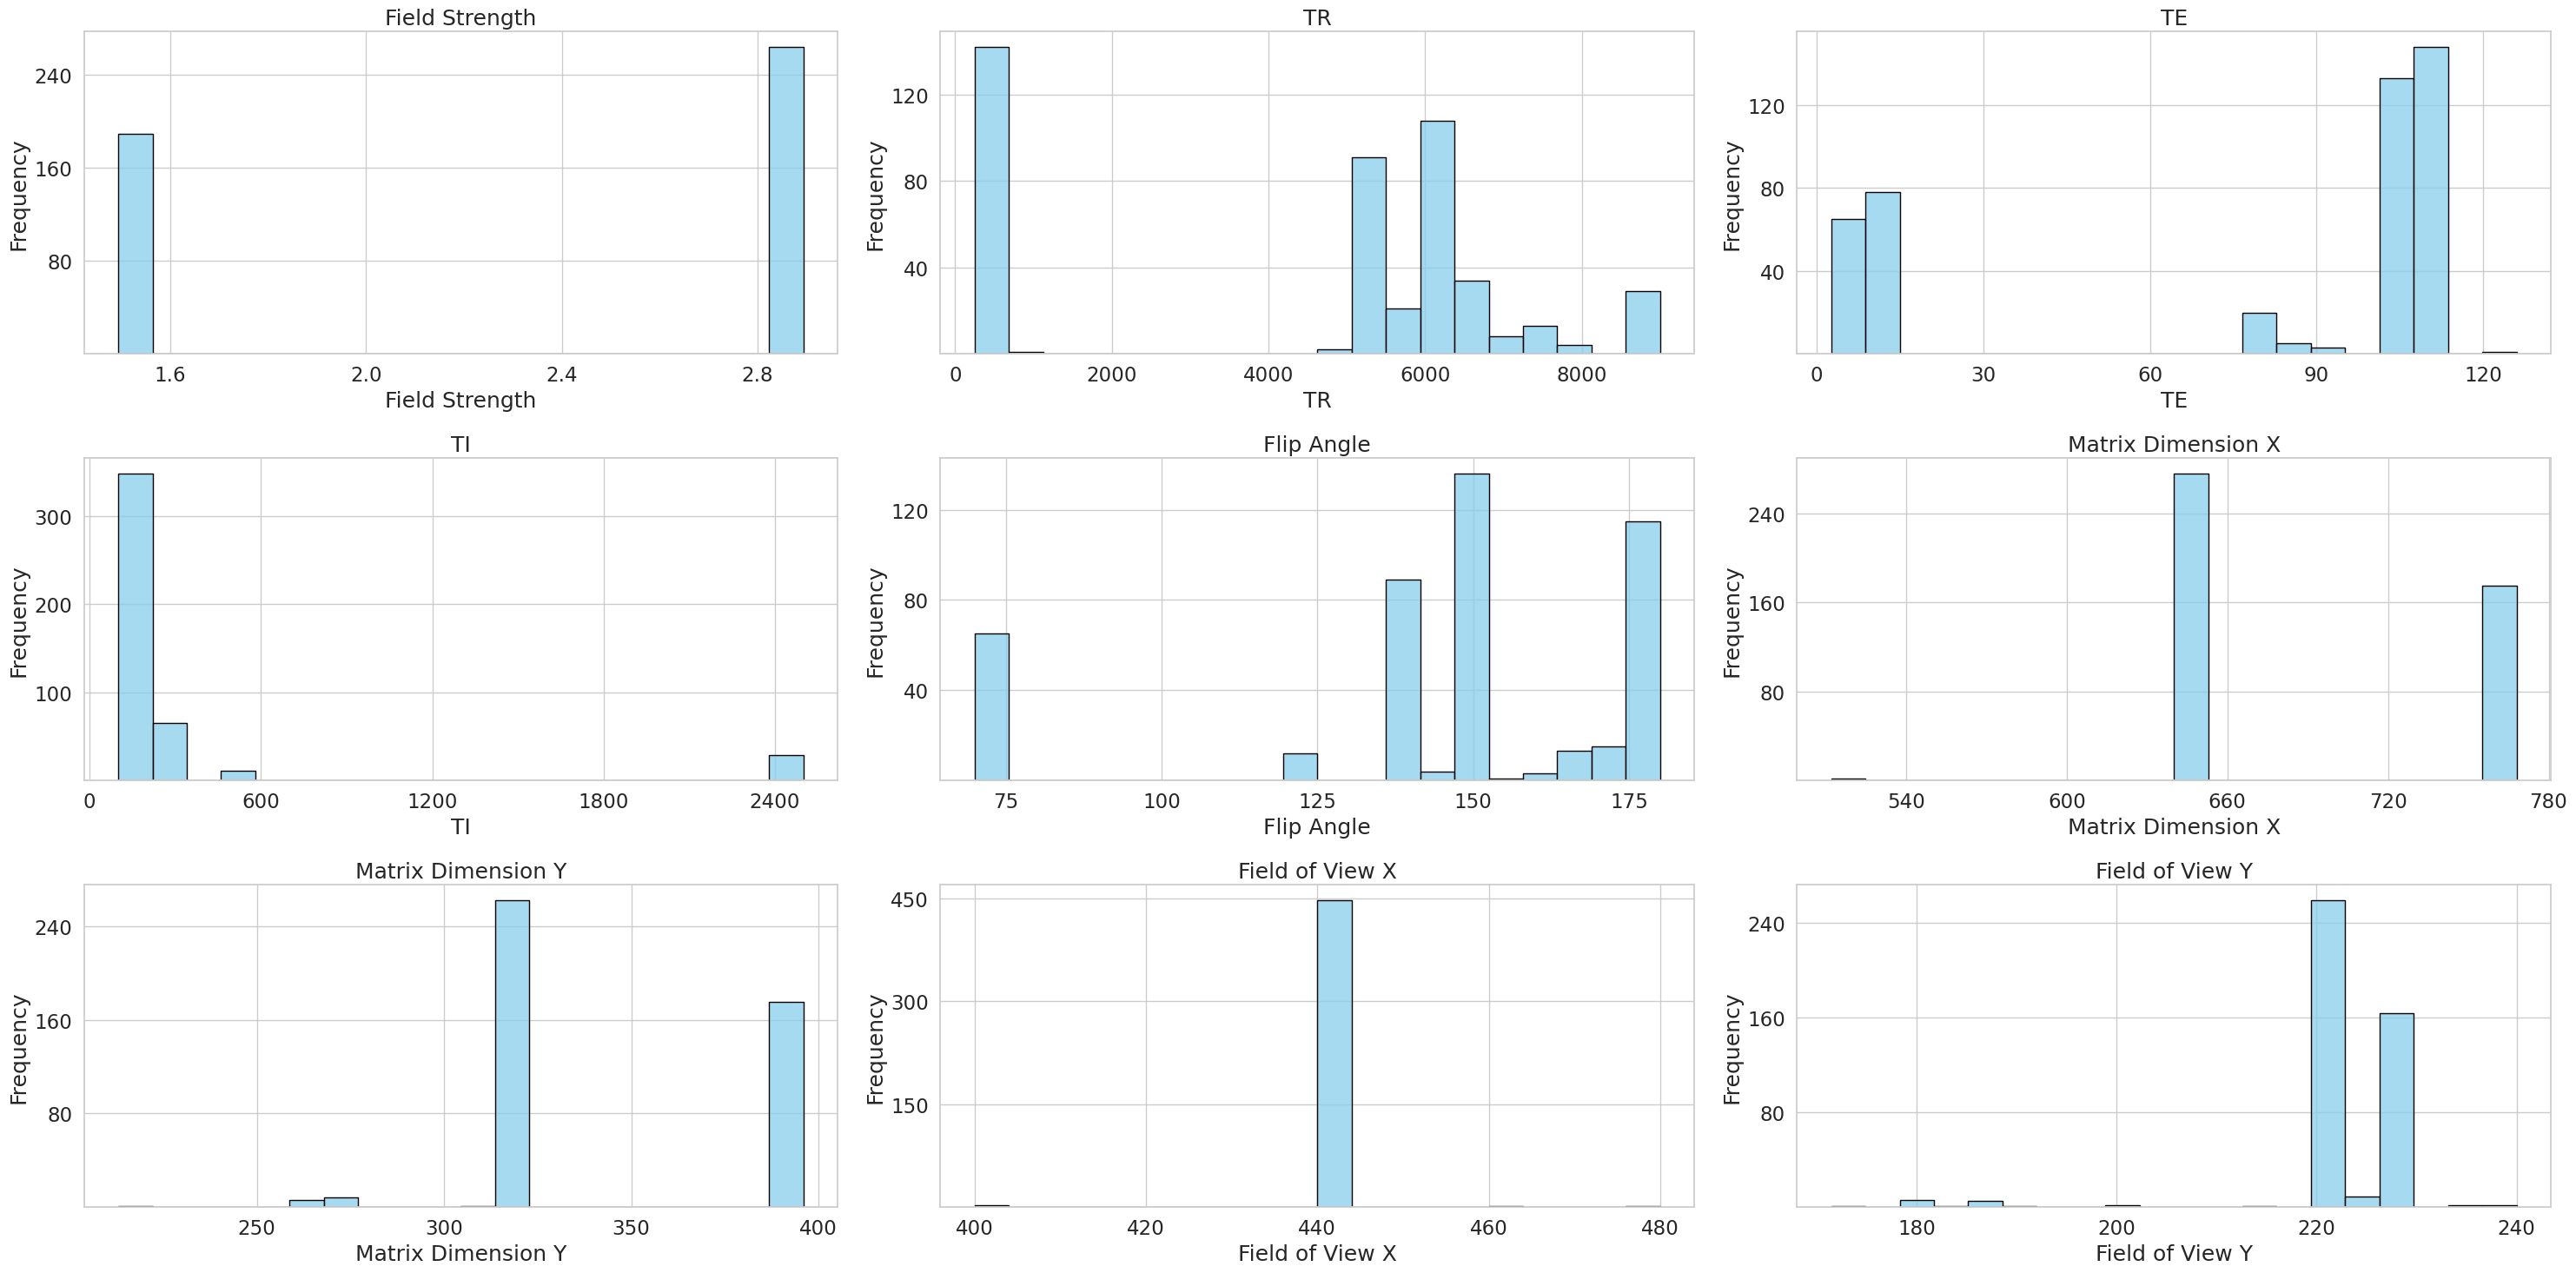

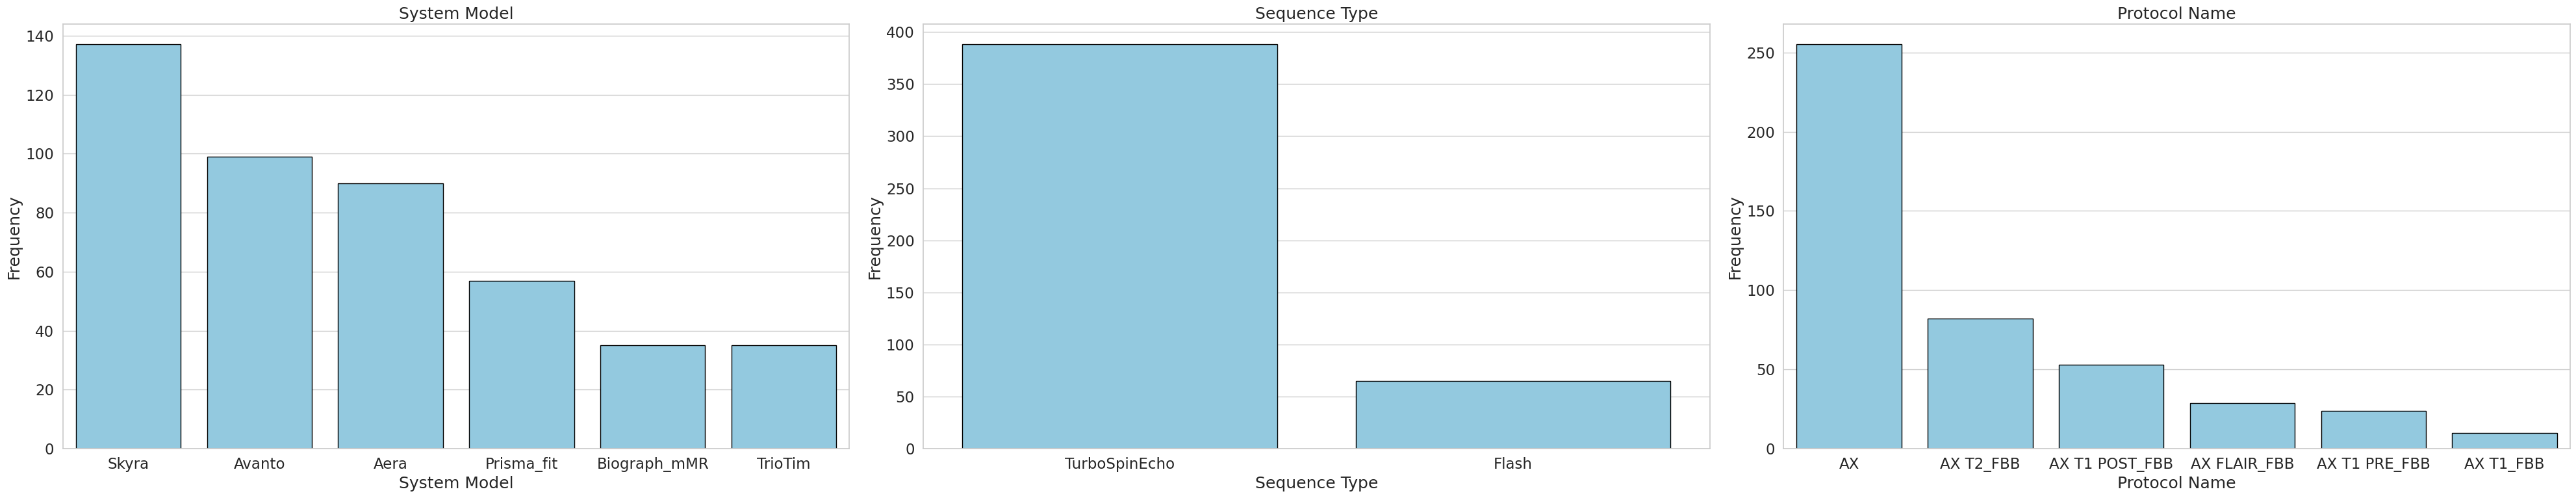

In [4]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", palette="muted", font_scale=1.5)

for key in continuous_keys:
    metadata_df[key] = pd.to_numeric(metadata_df[key], errors='coerce')

fig, axs = plt.subplots(3, 3, figsize=(30, 15))
axs = axs.flatten()

for ax, key in zip(axs, continuous_keys):
    sns.histplot(metadata_df[key].dropna(), bins=20, ax=ax, color='skyblue', edgecolor='black')
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5, prune='both'))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
    ax.set_title(key)
    ax.set_xlabel(key)
    ax.set_ylabel("Frequency")

fig.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(40, 8))
axs = axs.flatten()

for ax, key in zip(axs, categorical_keys):
    counts = metadata_df[key].value_counts(dropna=False)
    sns.barplot(x=counts.index.astype(str), y=counts.values, ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(key)
    ax.set_xlabel(key)
    ax.set_ylabel("Frequency")

fig.tight_layout()
plt.show()